In [1]:
run_name = 'run16'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yaml, sys
from datetime import datetime
from prettytable import PrettyTable
from scipy.interpolate import splrep, splev

In [3]:
sys.path.append('.')
from getDataFromMysql import getData
from temp_utils import adc2T
from resistors_utils import V2power, power2V

In [4]:
samples = yaml.load(open('samples/runs.yml'), Loader=yaml.FullLoader)
sensor_maps = yaml.load(open('samples/sensor_map.yml'), Loader=yaml.FullLoader)
dset = samples[run_name]
sensor_map = sensor_maps[dset['sensor_map']]

In [5]:
def getRelativeTime(data, units='s'):
    dt_s = map(lambda x: (x-data[0][0]).total_seconds(), data[:,0])
    conv = {'s':1, 'm':60., 'h':3600}
    
    return np.array(dt_s)/conv[units]

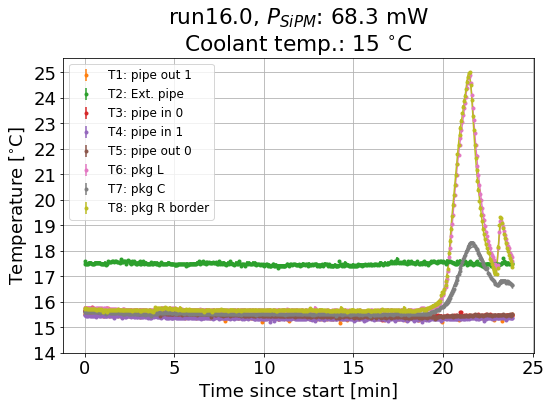

In [6]:
plt.rcParams.update({'font.size': 18})
plotGradient = False
for i_t, times in enumerate(dset['times']):
    if plotGradient:
        fig, ax = plt.subplots(2, 1, figsize=(8,8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True, sharey=False)
    else:
        fig = plt.figure(figsize=(8,6))
        ax = [plt.gca()]
    data = np.array(getData(times))
    
    t = getRelativeTime(data, 'm')
    
    for i in range(1, len(sensor_map)+1):
        T = adc2T(data[:,i])
        T_UP = adc2T(data[:,i]+1)
        err = np.hypot(T - T_UP, 0.05)
        
    
        label = 'T{}: {}'.format(i, sensor_map[i-1])
        ax[0].errorbar(t, T, err, fmt='.', color='C'+str(i), label=label)      
        
        f_spl = splrep(t, T,k=5,s=T.shape[0]*2e-3)
        ax[0].plot(t, splev(t, f_spl), color='C'+str(i))
        if plotGradient:
            grad_T = splev(t, f_spl, der=1)
            ax[1].plot(t, grad_T, color='C'+str(i))
        
        
        if i == len(sensor_map):
            if np.sum(data[:,10]) > 0:
                ax[0].plot(t, data[:,10], color='k', label='ambient')
            p, _ = V2power(dset['voltage'])
            if 'steady' in dset.keys() and len(dset['steady']) > i_t:
                low, up = ax[0].set_ylim()
                ax[0].plot(2*[dset['steady'][i_t][0]], [low, up], '--', color='magenta')
                ax[0].plot(2*[dset['steady'][i_t][1]], [low, up], '--', color='magenta')
            power_txt = r'$P_{SiPM}$'+': {:.1f} mW'.format(1e3*p)
            if 'heatPadV' in dset.keys():
                power_txt += r', $P_{heat}$' + ' = {:.2f} W'.format(V2power(dset['heatPadV'], 150., 1.,1.)[0])
            power_txt+='\nCoolant temp.: {} '.format(dset['temp'])+r'$^{\circ}$C'
            ax[0].set_title(run_name+'.{}, '.format(i_t)+power_txt)
            ax[0].legend(loc='best', prop={'size': 12})
            ax[-1].set_xlabel('Time since start [min]')
            ax[0].set_ylabel(r'Temperature [$^{\circ}$C]')
            ax[0].grid(axis='x')
            ax[0].grid(axis='y')            
            low, up = ax[0].set_ylim()
            ax[0].set_yticks(np.arange(np.floor(low), np.ceil(up), 1.))
            if plotGradient:
                ax[1].grid(axis='x')
                ax[1].set_ylabel(r'$\Delta$T [$^{\circ}$C/min]')
                ax[1].set_ylim(-0.2, 0.2)
            
    plt.tight_layout(h_pad=0.05)
    fn = 'fig/'+run_name
    fn += '_'+str(i_t) if len(dset['times']) > 1 else ''
    fn += '.png'
    fig.savefig(fn)

In [7]:
output = []
for i_t, times in enumerate(dset['times']):
    if not 'steady' in dset.keys() or len(dset['steady']) <= i_t:
        continue
    data = np.array(getData(times))
    t = getRelativeTime(data, 'm')
    steady_lims = dset['steady'][i_t]
    sel = np.logical_and(t > steady_lims[0], t < steady_lims[1])
    t = t[sel]
    results = []
    for i in range(1, len(sensor_map)+1):
        T = adc2T(data[:,i])[sel]
        
        res = {}
        res['avg'] = np.mean(T)
        res['std'] = np.std(T)
        res['disp'] = 0.5*(np.percentile(T, 84) - np.percentile(T, 16))
        res['min'] = np.min(T)
        res['max'] = np.max(T)
        
        p = np.polyfit(t, T, 1)
        res['slope'] = p[0]
        results.append(res)
    
    
    i1, i2 = np.argsort([res['avg'] for res in results])[:2]
    Tcool = 0.5*(results[i1]['avg'] + results[i2]['avg'])
    for r in results:
        r['coolDiff'] = r['avg'] - Tcool
        
    output.append(results)

In [8]:
fl = open('results/'+run_name+'.txt', 'w')
for out in output:
    table = PrettyTable([' '] + sensor_map)
    fl.write('#'+','.join([' '] + sensor_map) + '\n')
    for k in np.sort(out[0].keys()):
        row = [k.capitalize()]
        row += ['{:.3f}'.format(r[k]) for r in out]
        fl.write(','.join(row) + '\n')
        table.add_row(row)
    print table
    fl.write('\n\n')
fl.close()